In [10]:
import cv2
import os
import time
import matplotlib as plt
import numpy as np
import osmnx
from geopy.geocoders import Nominatim
import ee
import geemap
import rasterio
from PIL import Image
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt

In [11]:
## gee credentials

# Authenticate and initialize
ee.Authenticate()  # Run this only once; follow the on-screen instructions
# Explicitly set the project ID
ee.Initialize(project='ee-salvadorcantuarias') # Replace 'your-project-id' with your actual Google Cloud project ID

In [12]:
# Step 1: Get OSM Bounding Box for Both OSMnx & GEE
def get_osm_boundary(city_name):
    geolocator = Nominatim(user_agent="geoapi", timeout=10)
    try:
        location = geolocator.geocode(city_name, exactly_one=True)
        if location:
            bbox = location.raw.get('boundingbox', None)
            if bbox:
                # The bounding box from Nominatim is [lat_min, lat_max, lon_min, lon_max]
                lat_min, lat_max, lon_min, lon_max = map(float, bbox)
                return {
                    "bbox": (lon_min, lat_min, lon_max, lat_max),
                    "gee_rectangle": ee.Geometry.BBox(lon_min, lat_min, lon_max, lat_max)  # (west, south, east, north)
                }
    except Exception as e:
        print(f"Error fetching bbox for {city_name}: {e}")
    return None

In [13]:

# Step 2: Generate Street Layout Using OSMnx
def generate_street_layout(city_name):
    boundary_data = get_osm_boundary(city_name)
    if boundary_data is None:
        print(f"❌ Error: Could not find {city_name} boundary in OSM.")
        return None, None

    print(f"✅ City boundary found! Clipping street network to {city_name}...")
    lat_min, lat_max, lon_min, lon_max = boundary_data["bbox"]

    # OSMnx expects (north, south, east, west)
    graph = ox.graph_from_bbox(boundary_data["bbox"], network_type='drive')

    # Plot the graph
    fig, ax = ox.plot_graph(
        graph, node_size=0, bgcolor='#FFFFFF',
        edge_color='#000000', edge_linewidth=0.2,
        show=False, close=False
    )
        # Save image
    output_dir = "street_img/"
    os.makedirs(output_dir, exist_ok=True)
    image_path = os.path.join(output_dir, f"{city_name}_street_network.png")
    fig.savefig(image_path, dpi=400, bbox_inches='tight')
    print(f"📷 Saved street network: {image_path}")

    return fig, ax

In [14]:

# Step 3: Generate Elevation as a NumPy Array from NASADEM in GEE
def generate_elevation_numpy(city_name):
    print(f"🔍 Searching for {city_name} in OpenStreetMap...")
    boundary_data = get_osm_boundary(city_name)
    if boundary_data is None:
        print(f"❌ Error: Could not find {city_name} boundary in OSM.")
        return None, None
    gee_rectangle = boundary_data["gee_rectangle"]

    print(f"✅ City boundary found! Clipping elevation map to {city_name}...")

    # Load the NASADEM elevation dataset
    dataset = ee.Image('NASA/NASADEM_HGT/001')
    elevation = dataset.select('elevation')

    # Clip the elevation data to the city's bounding box
    elevation_city = elevation.clip(gee_rectangle)

    # Define export file paths
    tif_file = f"elevation_img/elevation_tif/{city_name}_elevation.tif"
    png_file = f"elevation_img/elevation_png/{city_name}_elevation.png"
    npy_file = f"elevation_img/elevation_npy/{city_name}_elevation.npy"

    # Export the elevation map as GeoTIFF
    geemap.ee_export_image(
        elevation_city, filename=tif_file, region=gee_rectangle, file_per_band=False
    )
    print(f"✅ GeoTIFF saved: {tif_file}")

    # Convert GeoTIFF to PNG & NumPy Array
    if os.path.exists(tif_file):
        with rasterio.open(tif_file) as src:
            array = src.read(1)  # Read first band

            # Replace NoData values with 0 if needed
            if src.nodata is not None:
                array[array == src.nodata] = 0

            # Save as NumPy array for AI processing
            np.save(npy_file, array)
            print(f"✅ NumPy array saved: {npy_file}")

            # Normalize elevation values (0-255 grayscale) for visualization
            min_val, max_val = np.percentile(array, (2, 98))
            normalized_array = ((array - min_val) / (max_val - min_val)) * 255
            normalized_array = np.clip(normalized_array, 0, 255).astype(np.uint8)

            # Convert to grayscale image
            img = Image.fromarray(normalized_array)
            img = img.convert("L")
            img.save(png_file)

            # Show the processed elevation map
            plt.figure(figsize=(8, 8))
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(f"{city_name} Elevation Map")
            plt.show()
        print(f"✅ PNG saved: {png_file}")

        return npy_file, png_file
    else:
        print("❌ Error: GeoTIFF file not found.")
        return None, None

In [15]:

# Step 4: Overlay Elevation and Street Layout Maps
def overlay_maps(city_name):
    elevation_file = f"elevation_img/elevation_png/{city_name}_elevation.png"
    street_file = f"street_img/{city_name}_street_network.png"
    overlay_file = f"overlay_img/{city_name}_overlay.png"

    if not os.path.exists(elevation_file):
        print(f"❌ Error: Elevation map for {city_name} not found!")
        return None
    if not os.path.exists(street_file):
        print(f"❌ Error: Street layout for {city_name} not found!")
        return None

    # Load images
    elevation_img = cv2.imread(elevation_file, cv2.IMREAD_GRAYSCALE)  # Grayscale elevation
    street_img = cv2.imread(street_file, cv2.IMREAD_UNCHANGED)          # Color street layout

    # Resize elevation image to match street image dimensions if needed
    elevation_resized = cv2.resize(elevation_img, (street_img.shape[1], street_img.shape[0]))
    elevation_colored = cv2.cvtColor(elevation_resized, cv2.COLOR_GRAY2BGR)

    # Extract street edges and create an overlay (red edges)
    street_edges = cv2.Canny(street_img, 50, 150)
    street_overlay = np.zeros_like(elevation_colored)
    street_overlay[street_edges > 0] = (0, 0, 255)  # Red color for streets

    # Blend the images
    overlay_result = cv2.addWeighted(elevation_colored, 1, street_overlay, 1, 0)
    cv2.imwrite(overlay_file, overlay_result)
    print(f"✅ Overlay saved: {overlay_file}")

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(overlay_result, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Overlay of {city_name} Elevation & Streets")
    #plt.show()
    return overlay_file


✅ City boundary found! Clipping street network to samara, russia...
📷 Saved street network: street_img/samara, russia_street_network.png
🔍 Searching for samara, russia in OpenStreetMap...
✅ City boundary found! Clipping elevation map to samara, russia...
Generating URL ...
Please wait ...
Data downloaded to c:\Users\salva\OneDrive\Escritorio\amoebas studio\Applied_research_studio\rcs\elevation_img\elevation_tif\samara, russia_elevation.tif
✅ GeoTIFF saved: elevation_img/elevation_tif/samara, russia_elevation.tif
✅ NumPy array saved: elevation_img/elevation_npy/samara, russia_elevation.npy


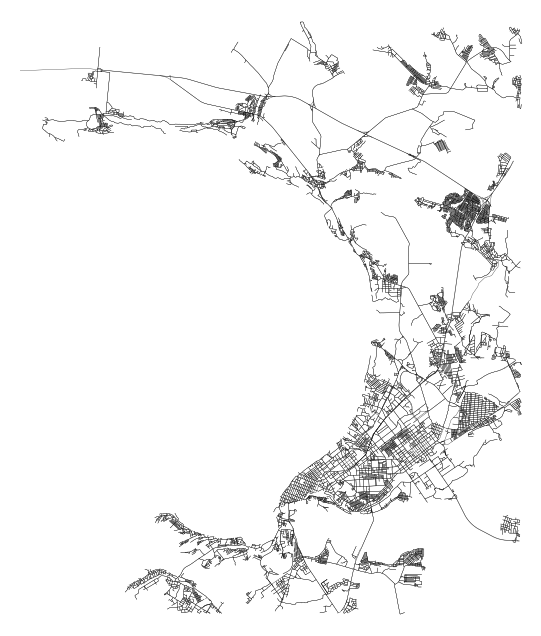

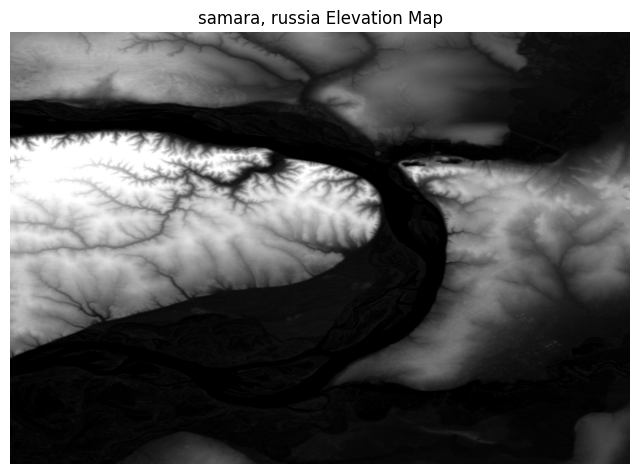

✅ PNG saved: elevation_img/elevation_png/samara, russia_elevation.png
✅ Overlay saved: overlay_img/samara, russia_overlay.png


'overlay_img/samara, russia_overlay.png'

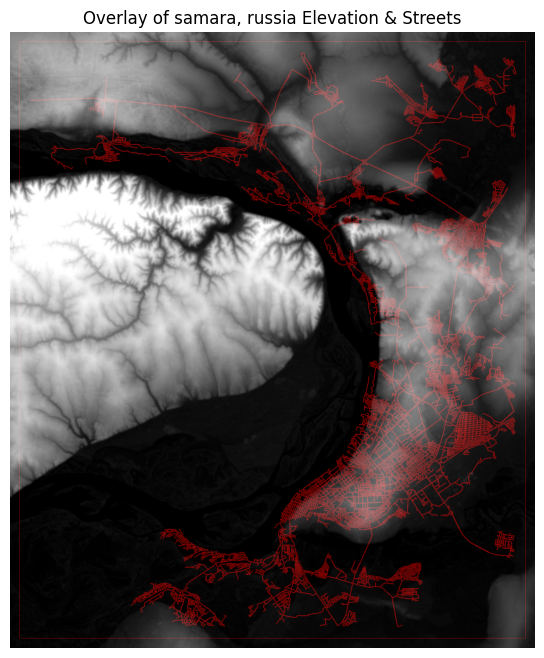

In [ ]:
df = pd.read_csv('rcs/cities_list.csv')
cities_list = df['City, Country'].tolist()

for city in cities_list:
    print(f"\n🌍 Processing: {city}...\n")

    try:
        # Define file paths
        elevation_file = f"rcs/elevation_img/elevation_png/{city}_elevation.png"
        street_file = f"rcs/street_img/{city}_street_network.png"
        overlay_file = f"rcs/overlay_img/{city}_overlay.png"
        npy_file = f"rcs/elevation_img/elevation_png/{city}_elevation.npy"

        # ✅ Check if files already exist to skip processing
        if os.path.exists(overlay_file):
            print(f"⚠️ {city} already processed, skipping...")
            continue

        # ✅ Generate Topography (Elevation) Map
        print("🔄 Generating elevation map...")
        elevation_result = generate_elevation_numpy(city)
        if elevation_result is None:
            print(f"⚠️ Skipping {city} due to missing elevation data.")
            continue

        # ✅ Generate Street Layout Map
        print("🔄 Generating street layout map...")
        street_result = generate_street_layout(city)
        if street_result is None:
            print(f"⚠️ Skipping {city} due to missing street data.")
            continue

        # ✅ Generate Overlay of Topography & Street Layout
        print("🔄 Generating overlay map...")
        overlay_result = overlay_maps(city)
        if overlay_result is None:
            print(f"⚠️ Skipping {city} due to overlay generation failure.")
            continue

        print(f"✅ Completed: {city} ✅\n")

        # ✅ Add a short delay to avoid API rate limits
        time.sleep(2)

    except Exception as e:
        print(f"❌ Error processing {city}: {e}")